In [1]:
# Preliminaries
from dietician_monitor import G, Patient, Consultation, patch_resource, get_monitor
from plotnine import *

Note that import caches classes (and variables, functions) defined in the imported package. This has two consequences:
1. Changes to the code-base of imported module will not reflect in the Jupyter notebook simply by re-running the import statement. Either restart the Jupyter notebook's kernel or explicitly reload.
2. The class G has attributes that are class-level. These include arrays that have items appended to them during a simulation run. These arrays will accumulate history *across* simulation runs unless cleared between runs. Remember, initialization of class-level attributes happens only once, during import. Unlike object-level attributes that are initialized via constructor call each time an object is instantiated. Provide a class-level method to clear accumulators and employ this method before each independent simulation run. 

### I. Monkey-Patch Monitor

Use the ```monitor_resource()``` method of class Consultation and pass the `dietician` as the name of the resource to monitor. Note that this method accepts a list of resource names but we have only one resource (i.e. deitician) in the model so we pass a list of one. The method gets the callback from ```get_monitor()``` function in the module 'dietician_monitor' and patches each named resource (here, dietician) using ```patch_resource()``` function from the same module.

Patching means that the get/put or request/release methods of the target resource are decorated to execute the callback before or after according to how the callback is passed. Use argument ```pre=``` to pass a callback that is executed before any of these resource methods and ```post=``` to pass a callback for execution afterwards. We have passed the callback to execute afterwards.

In [2]:
c = Consultation()
G.simulation_horizon = 30
c.monitor_resource(['dietician'])
res = c.run_once()

Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 2 entered the queue at 1.85
Patient 1 exited at 5.80, having spent 5.80 in clinic.
Patient 2 entered consultation at 5.80, having waited 3.95
Patient 3 entered the queue at 6.34
Patient 4 entered the queue at 8.45
Patient 2 exited at 8.91, having spent 7.06 in clinic.
Patient 3 entered consultation at 8.91, having waited 2.57
Patient 3 exited at 8.97, having spent 2.63 in clinic.
Patient 4 entered consultation at 8.97, having waited 0.52
Patient 5 entered the queue at 9.30
Patient 4 exited at 9.78, having spent 1.34 in clinic.
Patient 5 entered consultation at 9.78, having waited 0.48
Patient 6 entered the queue at 11.96
Patient 5 exited at 15.01, having spent 5.71 in clinic.
Patient 6 entered consultation at 15.01, having waited 3.05
Patient 6 exited at 17.06, having spent 5.10 in clinic.
Patient 7 entered the queue at 18.24
Patient 7 entered consultation at 18.24, having waited 0.00

Now obtain the results of the lone simulation run from class G. The attribute ```resource_monitor``` has tuples with the timestamp, the resource capacity employed and the resource capacity awaited. Compare the simulated trajectory from printed output with the contents of ```G.resource_monitor```. The first patient sees the dietician immediately, so the timestamp 0 has count 1 and awaited 0. 

In [3]:
# Plot
print(G.resource_monitor)
print(G.arrived)
#x_dietcian, y_dietician = list(zip(*G.resource_monitor["dietician"]))

{'dietician': [(0, 1, 0), (1.8502561531851716, 1, 1), (5.803099396379523, 0, 1), (6.338976903630266, 1, 1), (8.447971499540621, 1, 2), (8.912456720801188, 0, 2), (8.970304827356758, 0, 1), (9.303199270671396, 1, 1), (9.784124065717261, 0, 1), (11.957261607641335, 1, 1), (15.00909656594672, 0, 1), (17.05699087314544, 0, 0), (18.23729434633055, 1, 0), (20.667864609706157, 0, 0), (20.85463946789058, 1, 0), (21.8134201958678, 1, 1), (23.078978358119052, 0, 1), (24.3184813012776, 0, 0), (25.76864727868496, 1, 0), (28.505923239571203, 0, 0)]}
[0, 1.8502561531851716, 6.338976903630266, 8.447971499540621, 9.303199270671396, 11.957261607641335, 18.23729434633055, 20.85463946789058, 21.8134201958678, 25.76864727868496]


Thence, observe the following with each event:
1. A patient enters the queue and the capacity awaited is incremented by 1.
2. A patient enters consultation and the capacity employed is incremented by 1.
3. A patient exits after consultation, the capacity employed decreases by 1. 

When a patient is in queue waiting for consultation, then they should see the dietician as soon as available. One consultation begins as soon as the other ends. **HOWEVER** we note that this is reflected in the printed output but not in the monitor from monkey-patched resource methods. 

## COULD THIS BE A BUG?

We have specified that the callback log the resource utilization with timestamp as soon as the resource method (put/get or request/release) has run. This is not happening in the situation when the one entity's finish coincides with the next entity's start. Unfortunately, this corrupts the data collected.

Let us see how the alternative approach fares.

## II. Monitor via Parallel Process

This approach launches a process with the sole purpose of gathering data in the shared environment with the main process. Run the ```monitor_resource()``` method of class Consultation with ```proc_monitor=True```. Data are collected at regular time intervals. Contrast this with data collection when events occur in the monkey-patch approach. The data are gathered at finer resolution than the simulation step, e.g. 0.25 of a simulation time-step. (Think of Nyquist theorem.) 

In [4]:
c = Consultation()
G.simulation_horizon = 12
c.monitor_resource(['dietician'])
res = c.run_once(proc_monitor=True)

Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 2 entered the queue at 0.60
Patient 1 exited at 1.69, having spent 1.69 in clinic.
Patient 2 entered consultation at 1.69, having waited 1.09
Patient 2 exited at 1.78, having spent 1.18 in clinic.
Patient 3 entered the queue at 6.88
Patient 3 entered consultation at 6.88, having waited 0.00
Patient 4 entered the queue at 7.69
Patient 3 exited at 8.61, having spent 1.72 in clinic.
Patient 4 entered consultation at 8.61, having waited 0.91
Patient 4 exited at 11.05, having spent 3.36 in clinic.
Patient 5 entered the queue at 11.48
Patient 5 entered consultation at 11.48, having waited 0.00
Patient 6 entered the queue at 11.92


In [5]:
print(G.resource_monitor)
print(G.resource_utilization)

{'dietician': [(0, 1, 0), (0.6043169951667838, 1, 1), (1.6894583988345633, 0, 1), (1.7819189015450085, 0, 0), (6.881884898150481, 1, 0), (7.691770053165266, 1, 1), (8.606601821260453, 0, 1), (11.053353407551217, 0, 0), (11.483462799541595, 1, 0), (11.915445569899843, 1, 1)]}
{'dietician': [(0, 0, 0), (0.25, 1, 0), (0.5, 1, 0), (0.75, 1, 1), (1.0, 1, 1), (1.25, 1, 1), (1.5, 1, 1), (1.75, 1, 0), (2.0, 0, 0), (2.25, 0, 0), (2.5, 0, 0), (2.75, 0, 0), (3.0, 0, 0), (3.25, 0, 0), (3.5, 0, 0), (3.75, 0, 0), (4.0, 0, 0), (4.25, 0, 0), (4.5, 0, 0), (4.75, 0, 0), (5.0, 0, 0), (5.25, 0, 0), (5.5, 0, 0), (5.75, 0, 0), (6.0, 0, 0), (6.25, 0, 0), (6.5, 0, 0), (6.75, 0, 0), (7.0, 1, 0), (7.25, 1, 0), (7.5, 1, 0), (7.75, 1, 1), (8.0, 1, 1), (8.25, 1, 1), (8.5, 1, 1), (8.75, 1, 0), (9.0, 1, 0), (9.25, 1, 0), (9.5, 1, 0), (9.75, 1, 0), (10.0, 1, 0), (10.25, 1, 0), (10.5, 1, 0), (10.75, 1, 0), (11.0, 1, 0), (11.25, 0, 0), (11.5, 1, 0), (11.75, 1, 0)]}


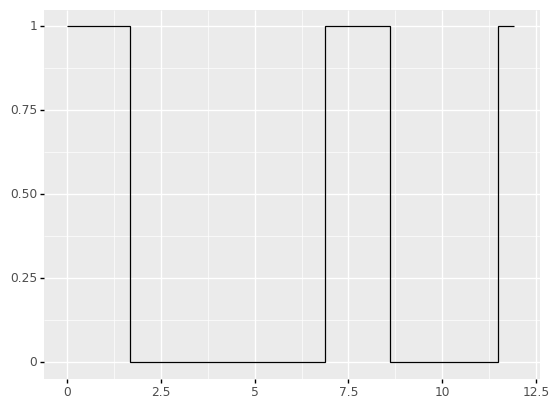

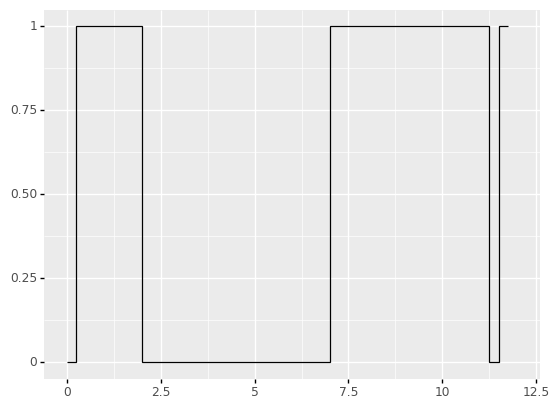

<ggplot: (319372319)>

In [18]:
x_monkey, y_monkey, _ = list(zip(*G.resource_monitor["dietician"]))
x_monitr, y_monitr, _ = list(zip(*G.resource_utilization['dietician']))

pMonkey = ggplot(aes(x=x_monkey, y=y_monkey)) + geom_step() + xlim(0, G.simulation_horizon)
ggplot.draw(pMonkey)
pMonitr = ggplot(aes(x=x_monitr, y=y_monitr)) + geom_step() + xlim(0, G.simulation_horizon)
pMonitr

In [7]:
import simpy
env = simpy.Environment
res = simpy.Resource(env=env, capacity=1)
print(type(res))
type(res) == 'simpy.resources.resource.Resource'
isinstance(res, simpy.resources.resource.Resource)

<class 'simpy.resources.resource.Resource'>


True